In [1]:
import os
os.environ['PROJ_LIB'] = '/data/keeling/a/sshu3/anaconda2/share/proj'
from mpl_toolkits.basemap import Basemap, cm, shiftgrid,maskoceans
from netCDF4 import Dataset as NetCDFFile
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy.ma as ma
from scipy.interpolate import griddata
from pyresample import geometry,image, kd_tree
import math
import copy as cp
import isamcalc_lib as isam

In [2]:
# Analyze the change of soil temperature, soil moisture and litter input
# Dave's mask
# Obatin permafrost area mask from Brown et al., 1998 [0<code<23 are permafrost]
# Open NCSCD as observation
path='/data/jain1/c/sshu3/SBGC/data/ggd318_permafrost_and_ice_map_circumarctic/permafrost_mask.nc'
#path='/data/jain1/c/sshu3/SBGC/data/NCSCDv2_Circumpolar_netCDF_05deg/ncscd_masked_0.5x0.5.nc'
nclu_pf=NetCDFFile(path,'r')
pfcode = nclu_pf.variables['PFCODE'][:]
latnc_pf = nclu_pf.variables['Lat'][:]
lonnc_pf = nclu_pf.variables['Lon'][:]
nclu_pf.close()
temp = cp.deepcopy(pfcode[:, 0:360])
pfcode[:, 0:360] = pfcode[:, 360:720]
pfcode[:, 360:720] = temp
pfcode=pfcode[::-1,:]
temp = ma.masked_where(pfcode<1, pfcode)
ncscd_mask = ma.masked_where(temp>22, pfcode)

# Get the country mask of Norway (45400), Finland (42100), Sweden (47000) and Russia (46100)
path='/data/jain1/c/sshu3/SBGC/data/C14/C14processing/Ctry_halfdeg.nc'
nclu_ctry=NetCDFFile(path,'r')
ctrycode = nclu_ctry.variables['MASK_Country'][:]
latnc_ctry = nclu_ctry.variables['Lat'][:]
lonnc_ctry = nclu_ctry.variables['Lon'][:]
nclu_ctry.close()
norway = ma.masked_where(ctrycode != 45400, ctrycode)
finland = ma.masked_where(ctrycode != 42100, ctrycode)
sweden = ma.masked_where(ctrycode != 47000, ctrycode)
russia = ma.masked_where(ctrycode != 46100, ctrycode)

# Get the BONA(1), BOAS(7) and Europe (11) region mask from transcom region mask data 
# The Europe part is read in to exclude Asian Russia from the whole Russia
path='/data/jain1/c/sshu3/SBGC/data/C14/C14processing/transcom_regions_halfdeg.nc'
nclu_reg = NetCDFFile(path,'r')
regcode = nclu_reg.variables['transcom_regions'][:]
latnc_reg = nclu_reg.variables['lat'][:]
lonnc_reg = nclu_reg.variables['lon'][:]
nclu_reg.close()
bona = ma.masked_where(regcode != 1, regcode)
boas = ma.masked_where(regcode != 7, regcode)
eu = ma.masked_where(regcode != 11, regcode)
eu_russia = ma.masked_where(eu.mask, russia)

# Combine three together, which is the same mask as Dave MCGuire's paper
temp_mask =eu_russia.mask & finland.mask & norway.mask & sweden.mask & bona.mask & boas.mask
temp = cp.deepcopy(temp_mask[:, 0:360])
temp_mask[:, 0:360] = temp_mask[:, 360:720]
temp_mask[:, 360:720] = temp
dave_mask = temp_mask & ncscd_mask.mask

In [5]:
# Mask
path='/data/jain1/c/sshu3/SBGC/data/NCSCDv2_Circumpolar_netCDF_05deg/ncscdv2_soilc_0.5x0.5.nc'
nclu_obs=NetCDFFile(path,'r')
soc_ncscd_orig = nclu_obs.variables['soilc'][:]
latnc2 = nclu_obs.variables['lat'][:]
lonnc2 = nclu_obs.variables['lon'][:]
nclu_obs.close()

soc_ncscd = soc_ncscd_orig[0,:,:]
mask_permafrost = cp.deepcopy(ma.getmask(soc_ncscd))
another_mask = ma.masked_where(soc_ncscd<=0, soc_ncscd)
temp = cp.deepcopy(mask_permafrost[:, 0:360])
mask_permafrost[:, 0:360] = mask_permafrost[:, 360:720]
mask_permafrost[:, 360:720] = temp
temp = cp.deepcopy(another_mask[:, 0:360])
another_mask[:, 0:360] = another_mask[:, 360:720]
another_mask[:, 360:720] = temp

# SOC and respiration
respath='/data/jain1/d/sshu3/SBGC_1d'
preind='1861_1870'
contemp='2001_2010'

# Read the 3D files, For ISAM-1D
# Historical
fp=respath+'/mean_bgc3d_'+preind+'.nc'
nclu_preind=NetCDFFile(fp,'r')
soclev_preind = nclu_preind.variables['soil_c_lev'][:]
resplev_preind = nclu_preind.variables['resp_lev'][:]
latnc = nclu_preind.variables['lat'][:]
lonnc = nclu_preind.variables['lon'][:]
#lonnc = ((lonnc - 180) % 360) - 180

# 20th century
fp=respath+'/mean_bgc3d_'+contemp+'.nc'
nclu_contemp=NetCDFFile(fp,'r')
soclev_contemp = nclu_contemp.variables['soil_c_lev'][:]
resplev_contemp = nclu_contemp.variables['resp_lev'][:]

# Path
respath='/data/jain1/d/sshu3/SBGC_0d'
preind='1861_1870'
contemp='2001_2010'

# Read the 3D files, For ISAM-0D
# Historical
fp=respath+'/mean_bgc2d_'+preind+'.nc'
nclu_preind=NetCDFFile(fp,'r')
soc0d_preind = nclu_preind.variables['soil_c'][:]
resp0d_preind = nclu_preind.variables['resp'][:]
#lonnc = ((lonnc - 180) % 360) - 180

# 20th century
fp=respath+'/mean_bgc2d_'+contemp+'.nc'
nclu_contemp=NetCDFFile(fp,'r')
soc0d_contemp = nclu_contemp.variables['soil_c'][:]
resp0d_contemp = nclu_contemp.variables['resp'][:]

# Open NCSCD as observation
path='/data/jain1/c/sshu3/SBGC/data/NCSCDv2_Circumpolar_netCDF_05deg/ncscd_masked_0.5x0.5.nc'
nclu_obs=NetCDFFile(path,'r')
soc_ncscd_orig = nclu_obs.variables['soilc'][:]
latnc2 = nclu_obs.variables['lat'][:]
lonnc2 = nclu_obs.variables['lon'][:]
soc_ncscd = soc_ncscd_orig[0,:,:]
#soc_ncscd[soc_ncscd<0] = float("nan")
#temp = soc_ncscd[:, 0:359]
#soc_ncscd[:, 0:359] = soc_ncscd[:, 360:719]
#soc_ncscd[:, 360:719] = temp[:,0:359]
#soc_ncscd[soc0d_contemp<0] = float("nan")

# Open the wetland fraction map to mask peatland 
respath = '/data/jain1/c/sshu3/SBGC/data/FW/'
fwet = 'min_fw_frac.nc'
fp=respath+fwet
nclu_wet=NetCDFFile(fp,'r')
wtld = nclu_wet.variables['FW'][:]
latnc3 = nclu_wet.variables['Lat'][:]
lonnc3 = nclu_wet.variables['Lon'][:]
wtld[wtld<0.05] = 0
wtld[wtld>=0.05] = 1
#wtld = np.flipud(wtld)

# Get the topsoil SOC (0-30cm) from 1D model
soc_top_preind = np.sum(soclev_preind[1:5,:,:], 0)
soc_top_contemp = np.sum(soclev_contemp[1:5,:,:], 0)

# topsoil resp
resp_top_preind = np.sum(resplev_preind[1:5,:,:], 0)
resp_top_contemp = np.sum(resplev_contemp[1:5,:,:], 0)

# Get the subsoil SOC (30-100cm) from 1D model
soc_sub_preind = np.sum(soclev_preind[5:7,:,:], 0)+0.3*soclev_preind[7,:,:]
soc_sub_contemp = np.sum(soclev_contemp[5:7,:,:], 0)+0.3*soclev_contemp[7,:,:]

# subsoil resp
resp_sub_preind = np.sum(resplev_preind[5:7,:,:], 0)+0.3*resplev_preind[7,:,:]
resp_sub_contemp = np.sum(resplev_contemp[5:7,:,:], 0)+0.3*resplev_contemp[7,:,:]

# Get the first 1m SOC
# 1D
soc_preind = soc_top_preind + soc_sub_preind
soc_contemp = soc_top_contemp + soc_sub_contemp

dsoc = soc_contemp - soc_preind
dsoc_topsoil = soc_top_contemp - soc_top_preind
dsoc_subsoil = soc_sub_contemp - soc_sub_preind

# 0D
dsoc0d = soc0d_contemp - soc0d_preind

# resp
# 1D
resp_preind = resp_top_preind + resp_sub_preind
resp_contemp = resp_top_preind + resp_sub_preind

dresp = resp_contemp - resp_preind

dresp0d = resp0d_contemp - resp0d_preind

# Turnover time is calculated using annual resp/SOC pool
# Since it is tough to get the SOC D14C with ISAM when performing spinup
# We right now don't use the D14C to derive turnover time. 
# 1D
# First method, only get the total bulk turnover by using the total soc and soil resp
# (This method seems to have some problem... But why?)
#tau_preind = soc_preind/resp_preind
#tau_contemp = soc_contemp/resp_contemp
#dtau = tau_contemp - tau_preind

# Second method, get the turnover time by calculating the turnover at each layer then calculate C werighted average.
# Get the turnover for each layer
tau_lev_preind = soclev_preind/resplev_preind
tau_lev_contemp = soclev_contemp/resplev_contemp

# Calculate the C mass weights
wt_preind = soclev_preind/soc_preind
wt_contemp = soclev_contemp/soc_contemp

tau_tmp_preind = wt_preind * tau_lev_preind
tau_tmp_contemp = wt_contemp * tau_lev_contemp

tau_preind = np.sum(tau_tmp_preind[1:7,:,:], 0)+0.3*tau_tmp_preind[7,:,:]
tau_contemp = np.sum(tau_tmp_contemp[1:7,:,:], 0)+0.3*tau_tmp_contemp[7,:,:]

dtau = tau_contemp - tau_preind

# 0D
tau0d_preind = soc0d_preind/resp0d_preind
tau0d_contemp = soc0d_contemp/resp0d_contemp

dtau0d = tau0d_contemp - tau0d_preind

# Also need to plot the ISAM-0D SOC results and NCSCD data to the right side 
# Seems like the respiration output from 1D model has some problem
# Shall be good now.
# Here open the 2D output for double checking the ISAM results
respath='/data/jain1/c/sshu3/SBGC/results/SBGC_regional/'
preind='1901_1910'
contemp='2001_2010'

# Historical
fp=respath+preind+'/mean_bgc2d_'+preind+'.nc'
nclu_preind=NetCDFFile(fp,'r')
resp_new_preind = nclu_preind.variables['resp'][:]

# 20th century
fp=respath+contemp+'/mean_bgc2d_'+contemp+'.nc'
nclu_contemp=NetCDFFile(fp,'r')
resp_new_contemp = nclu_contemp.variables['resp'][:]

dresp_new = resp_new_contemp - resp_new_preind

In [54]:
np.arange(5,13)

array([ 5,  6,  7,  8,  9, 10, 11, 12])

In [52]:
tss[5:13,223,214]

masked_array(data=[290.75888034385133, 290.8508343118493,
                   291.00123206799674, 291.2452415617533,
                   291.633719976359, 292.23328366096007,
                   293.1252303483953, 294.3826172293255],
             mask=[False, False, False, False, False, False, False, False],
       fill_value=-9999.0)

In [17]:
# Soil temperature
# First 0D
respath='/data/jain1/d/sshu3/SBGC_1d_noco2/'
prefix='Global_1DSBGC.bgp-monthly_3d_'
suffix='.nc'
month=['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
nlat = 360
nlon = 720

# Get the mean of first 1m soil
st_year = np.zeros((360, 720))
st_0d_preind_series = np.zeros((10, 360, 720))
st_0d_contemp_series = np.zeros((10, 360, 720))
st_0d_preind = np.zeros((360, 720))
st_0d_contemp = np.zeros((360, 720))

# Read the 3D files
# 1861 - 1870
for y in np.arange(1951,1961):
    st_year = np.zeros((12,360,720))
    #for i in np.arange(0,12):
    for i in np.arange(5,8):
        fp=respath+prefix+str(y)+'_'+month[i]+'.nc'
        nclu=NetCDFFile(fp,'r')
        tss = nclu.variables['c_tss'][:]
        latnc = nclu.variables['lat'][:]
        lonnc = nclu.variables['lon'][:]
        nclu.close()
        
        # Only use snow-free temperature
        # Also, we shall do a depth-werighted average
        snow_bottom  = tss[4,:,:]
        for l in np.arange(5,13):
            soilt = tss[i,:,:]
            soilt[snow_bottom>0] = np.float('nan')
            tss[i,:,:] = soilt
        #st = (np.nansum(tss[5:12,:,:], axis=0)+0.3*tss[12,:,:])/7.3
        st = np.average(tss[5:13,:,:], axis=0, weights=[0.017, 0.028, 0.045, 0.075, 0.124, 0.204, 0.336, 0.171])
        #st = np.sum(tss[5:10,:,:], axis=0)/5
        st_year[i,:,:] = st
        #st_year = st_year + st/3.
        
    st_0d_preind_series[(y-1951),:,:] = np.nanmean(st_year[5:8], axis=0)
    
# 2001 - 2010
for y in np.arange(2001,2011):
    st_year = np.zeros((12,360,720))
    #for i in np.arange(0,12):
    for i in np.arange(5,8):
        fp=respath+prefix+str(y)+'_'+month[i]+'.nc'
        nclu=NetCDFFile(fp,'r')
        tss = nclu.variables['c_tss'][:]
        latnc = nclu.variables['lat'][:]
        lonnc = nclu.variables['lon'][:]
        nclu.close()

        snow_bottom  = tss[4,:,:]
        for l in np.arange(5,13):
            soilt = tss[i,:,:]
            soilt[snow_bottom>0] = np.float('nan')
            tss[i,:,:] = soilt
        st = np.average(tss[5:13,:,:], axis=0, weights=[0.017, 0.028, 0.045, 0.075, 0.124, 0.204, 0.336, 0.171])
        #st = np.sum(tss[5:10,:,:], axis=0)/5
        st_year[i,:,:] = st
        #st_year = st_year + st/3.
    
    st_0d_contemp_series[(y-2001),:,:] = np.nanmean(st_year[5:8], axis=0)

st_0d_preind = np.mean(st_0d_preind_series, axis=0)
st_0d_preind[st_0d_preind<200] = np.float('nan')
st_0d_contemp = np.mean(st_0d_contemp_series, axis=0)
st_0d_diff = st_0d_contemp - st_0d_preind
## Delete anomaly grids
#st_0d_diff[st_0d_diff<-2] = 0

/data/keeling/a/sshu3/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: Mean of empty slice
/data/keeling/a/sshu3/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: Mean of empty slice
/data/keeling/a/sshu3/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in less


In [16]:
# Better to have the rate of temeprature change for each decade, then the change of SOC stock can make sense.
a[5:8]


[6, 7, 8]

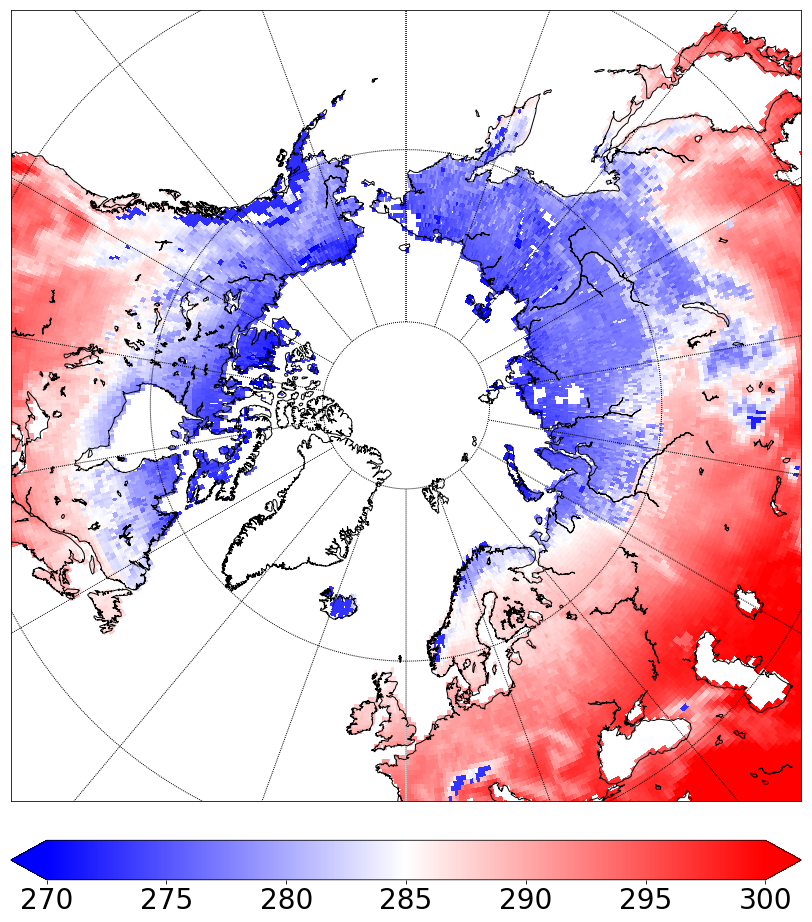

In [20]:
# Mask all regions outside the northern permafrost extent
st_0d_preind_plot = ma.masked_array(st_0d_preind, mask=another_mask.mask)
st_0d_contemp_plot = ma.masked_array(st_0d_contemp, mask=another_mask.mask)
#st_0d_preind_plot.mask = another_mask.mask
st_0d_diff_plot = ma.masked_array(st_0d_diff, mask=another_mask.mask)
#st_0d_diff.mask = another_mask.mask

# Plot the 1-m soil temperature
# Plot the figure1
# Comparison of 1m SOC stock between two models and to the NCSCD data
fig = plt.figure(figsize=(20,16))

# ax1 = fig.add_subplot(111)
# #ax1.set_title("ISAM-1D SOC stock (1m)",fontsize=32)
# map = Basemap(projection='npstere',boundinglat=45,lon_0=0,resolution='l')
# # draw coastlines, state and country boundaries, edge of map.
# map.drawcoastlines()
# lon,lat = np.meshgrid(lonnc,latnc) #Returns coordinate matrices from coordinate vectors
# x,y = map(lon,lat)
# cs1 = map.pcolormesh(x,y,st_0d_preind_plot[:,:],
#               norm=colors.Normalize(vmin=265.,vmax=290.),cmap=plt.cm.jet) # use log color scale,
# cbar = map.colorbar(cs1,location='bottom',pad="5%",extend='both')
# map.drawparallels(np.arange(-80.,81.,20.))#, labels=[True,True,True,True])
# map.drawmeridians(np.arange(-180.,181.,20.))#, labels=[True,True,True,True])
# cbar.ax.tick_params(labelsize=18) 
# plt.annotate('(a)', xy=(0.02, 0.9), xycoords='axes fraction', fontsize=24)

#ax2 = fig.add_subplot(111)
#ax2.set_title("ISAM-0D SOC stock (1m)",fontsize=32)
map = Basemap(projection='npstere',boundinglat=45,lon_0=0,resolution='l')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
lon,lat = np.meshgrid(lonnc,latnc) #Returns coordinate matrices from coordinate vectors
x,y = map(lon,lat)
cs = map.pcolormesh(x,y,st_0d_preind[:,:],
              norm=colors.Normalize(vmin=270.,vmax=300.),cmap=plt.cm.bwr) # use log color scale,
map.drawparallels(np.arange(-80.,81.,20.))#, labels=[True,True,True,True])
map.drawmeridians(np.arange(-180.,181.,20.))#, labels=[True,True,True,True])
cbar = map.colorbar(cs,location='bottom',pad="5%",extend='both')
cbar.ax.tick_params(labelsize=28) 
#plt.annotate('(b)', xy=(0.02, 0.9), xycoords='axes fraction', fontsize=24)

plt.show()
#plt.savefig('FigS4.png')

In [ ]:
(isam.q10(1.68, 7.1) - isam.q10(1.68, 7.0))/isam.q10(1.68, 7.0)

In [ ]:
isam.q10(1.68, 10.0)

In [ ]:
isam.q10(1.68, 5.0)

In [ ]:
# Area of each grid (m2)
nlon = 720
nlat = 360
grid_area = np.zeros((nlat, nlon))
EARTH_AREA = 5.096e14
lat = np.arange(-89.75, 90.25, 0.5)
res = 0.5

for i in np.arange(0,nlon):
    for j in np.arange(0,nlat):
        grid_area[j,i] = (EARTH_AREA/2)*abs(np.sin((lat[j] - res/2)*math.pi/180) -
                np.sin((lat[j] + res/2)*math.pi/180))/(360/res)

# Get the mean temperature change
grid_area_t = cp.deepcopy(grid_area)
grid_area_t[st_0d_preind<200] = 0.
st_0d_diff_area = st_0d_preind * grid_area
st_0d_diff_mean = np.sum(st_0d_diff_area)/np.sum(grid_area_t)


In [ ]:
# NPP
# ISAM 1D
respath='/data/jain1/c/sshu3/SBGC/results/SBGC_regional/'
preind='1901_1910'
contemp='2001_2010'

# Historical
fp=respath+preind+'/mean_bgp2d_'+preind+'.nc'
nclu_preind=NetCDFFile(fp,'r')
anpp_preind = nclu_preind.variables['anpp_avg_yr'][:]

# 20th century
fp=respath+contemp+'/mean_bgp2d_'+contemp+'.nc'
nclu_contemp=NetCDFFile(fp,'r')
anpp_contemp = nclu_contemp.variables['anpp_avg_yr'][:]

anpp_diff = anpp_contemp - anpp_preind
anpp_diff_area = anpp_diff * grid_area
tot_anpp_diff = np.nansum(anpp_diff_area)

# ISAM 0D
respath='/data/jain1/c/sshu3/SBGC/results/SBGC_0d/'
preind='1901_1910'
contemp='2001_2010'

# Historical
fp=respath+preind+'/mean_bgp2d_'+preind+'.nc'
nclu_preind=NetCDFFile(fp,'r')
anpp0d_preind = nclu_preind.variables['anpp_avg_yr'][:]

# 20th century
fp=respath+contemp+'/mean_bgp2d_'+contemp+'.nc'
nclu_contemp=NetCDFFile(fp,'r')
anpp0d_contemp = nclu_contemp.variables['anpp_avg_yr'][:]

anpp0d_diff = anpp0d_contemp - anpp0d_preind
anpp0d_diff_area = anpp0d_diff * grid_area
tot_anpp0d_diff = np.nansum(anpp0d_diff_area)


In [ ]:
# Mask all regions outside the northern permafrost extent
anpp_preind_plot = ma.masked_array(anpp_preind, mask=another_mask.mask)
anpp_contemp_plot = ma.masked_array(anpp_contemp, mask=another_mask.mask)
anpp_diff_plot = ma.masked_array(anpp_diff, mask=another_mask.mask)

# Plot the ANPP
fig = plt.figure(figsize=(20,8))

ax1 = fig.add_subplot(121)
#ax1.set_title("ISAM-1D SOC stock (1m)",fontsize=32)
map = Basemap(projection='npstere',boundinglat=45,lon_0=0,resolution='l')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
lon,lat = np.meshgrid(lonnc,latnc) #Returns coordinate matrices from coordinate vectors
x,y = map(lon,lat)
cs1 = map.pcolormesh(x,y,anpp_contemp_plot[:,:],
              norm=colors.Normalize(vmin=0.,vmax=500.),cmap=plt.cm.jet) # use log color scale,
cbar = map.colorbar(cs1,location='bottom',pad="5%",extend='both')
map.drawparallels(np.arange(-80.,81.,20.))#, labels=[True,True,True,True])
map.drawmeridians(np.arange(-180.,181.,20.))#, labels=[True,True,True,True])
cbar.ax.tick_params(labelsize=18) 
plt.annotate('(a)', xy=(0.02, 0.9), xycoords='axes fraction', fontsize=24)

ax2 = fig.add_subplot(122)
#ax2.set_title("ISAM-0D SOC stock (1m)",fontsize=32)
map = Basemap(projection='npstere',boundinglat=45,lon_0=0,resolution='l')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
cs = map.pcolormesh(x,y,anpp_diff_plot[:,:],
              norm=colors.Normalize(vmin=-150.,vmax=150.),cmap=plt.cm.jet) # use log color scale,
map.drawparallels(np.arange(-80.,81.,20.))#, labels=[True,True,True,True])
map.drawmeridians(np.arange(-180.,181.,20.))#, labels=[True,True,True,True])
cbar = map.colorbar(cs,location='bottom',pad="5%",extend='both')
cbar.ax.tick_params(labelsize=18) 
plt.annotate('(b)', xy=(0.02, 0.9), xycoords='axes fraction', fontsize=24)

plt.show()
#plt.savefig('FigS5.png')

In [ ]:
# Examine the NPP for 0D case
# Mask all regions outside the northern permafrost extent
anpp0d_preind_plot = ma.masked_array(anpp0d_preind, mask=another_mask.mask)
anpp0d_contemp_plot = ma.masked_array(anpp0d_contemp, mask=another_mask.mask)
anpp0d_diff_plot = ma.masked_array(anpp0d_diff, mask=another_mask.mask)

# Plot the ANPP
# Comparison of 1m SOC stock between two models and to the NCSCD data
fig = plt.figure(figsize=(20,16))

ax1 = fig.add_subplot(221)
#ax1.set_title("ISAM-1D SOC stock (1m)",fontsize=32)
map = Basemap(projection='npstere',boundinglat=45,lon_0=0,resolution='l')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
lon,lat = np.meshgrid(lonnc,latnc) #Returns coordinate matrices from coordinate vectors
x,y = map(lon,lat)
cs1 = map.pcolormesh(x,y,anpp_contemp_plot[:,:],
              norm=colors.Normalize(vmin=0.,vmax=500.),cmap=plt.cm.jet) # use log color scale,
cbar = map.colorbar(cs1,location='bottom',pad="5%",extend='both')
map.drawparallels(np.arange(-80.,81.,20.))#, labels=[True,True,True,True])
map.drawmeridians(np.arange(-180.,181.,20.))#, labels=[True,True,True,True])
cbar.ax.tick_params(labelsize=18) 
plt.annotate('(a)', xy=(0.02, 0.9), xycoords='axes fraction', fontsize=24)

ax2 = fig.add_subplot(222)
#ax2.set_title("ISAM-0D SOC stock (1m)",fontsize=32)
map = Basemap(projection='npstere',boundinglat=45,lon_0=0,resolution='l')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
cs = map.pcolormesh(x,y,anpp_diff_plot[:,:],
              norm=colors.Normalize(vmin=-150.,vmax=150.),cmap=plt.cm.jet) # use log color scale,
map.drawparallels(np.arange(-80.,81.,20.))#, labels=[True,True,True,True])
map.drawmeridians(np.arange(-180.,181.,20.))#, labels=[True,True,True,True])
cbar = map.colorbar(cs,location='bottom',pad="5%",extend='both')
cbar.ax.tick_params(labelsize=18) 
plt.annotate('(b)', xy=(0.02, 0.9), xycoords='axes fraction', fontsize=24)

ax3 = fig.add_subplot(212)
#ax1.set_title("ISAM-1D SOC stock (1m)",fontsize=32)
map = Basemap(projection='npstere',boundinglat=45,lon_0=0,resolution='l')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
lon,lat = np.meshgrid(lonnc,latnc) #Returns coordinate matrices from coordinate vectors
x,y = map(lon,lat)
cs1 = map.pcolormesh(x,y,anpp_preind_plot[:,:] - anpp0d_preind_plot[:,:],
              norm=colors.Normalize(vmin=-100.,vmax=100.),cmap=plt.cm.jet) # use log color scale,
cbar = map.colorbar(cs1,location='bottom',pad="5%",extend='both')
map.drawparallels(np.arange(-80.,81.,20.))#, labels=[True,True,True,True])
map.drawmeridians(np.arange(-180.,181.,20.))#, labels=[True,True,True,True])
cbar.ax.tick_params(labelsize=18) 
plt.annotate('(c)', xy=(0.02, 0.9), xycoords='axes fraction', fontsize=24)

# ax4 = fig.add_subplot(224)
# #ax2.set_title("ISAM-0D SOC stock (1m)",fontsize=32)
# map = Basemap(projection='npstere',boundinglat=45,lon_0=0,resolution='l')
# # draw coastlines, state and country boundaries, edge of map.
# map.drawcoastlines()
# cs = map.pcolormesh(x,y,anpp0d_diff_plot[:,:],
#               norm=colors.Normalize(vmin=-150.,vmax=150.),cmap=plt.cm.jet) # use log color scale,
# map.drawparallels(np.arange(-80.,81.,20.))#, labels=[True,True,True,True])
# map.drawmeridians(np.arange(-180.,181.,20.))#, labels=[True,True,True,True])
# cbar = map.colorbar(cs,location='bottom',pad="5%",extend='both')
# cbar.ax.tick_params(labelsize=18) 
# plt.annotate('(d)', xy=(0.02, 0.9), xycoords='axes fraction', fontsize=24)

plt.show()
#plt.savefig('Diffnpp_1D_minus_0D.png')

In [ ]:
# Mask all regions outside the northern permafrost extent
anpp_preind_dave = ma.masked_array(anpp_preind, mask=dave_mask)
anpp_contemp_dave = ma.masked_array(anpp_contemp, mask=dave_mask)
anpp_diff_dave = ma.masked_array(anpp_diff, mask=dave_mask)
anpp0d_preind_dave = ma.masked_array(anpp0d_preind, mask=dave_mask)
anpp0d_contemp_dave = ma.masked_array(anpp0d_contemp, mask=dave_mask)
anpp0d_diff_dave = ma.masked_array(anpp0d_diff, mask=dave_mask)

# Calculate modeled NPP
# Grid area
nlon = 720
nlat = 360
grid_area = np.ones((nlat, nlon))*-9999.
val1d_preind = np.ones((nlat, nlon))*float("nan")
val1d_contemp = np.ones((nlat, nlon))*float("nan")
val0d_preind = np.ones((nlat, nlon))*float("nan")
val0d_contemp = np.ones((nlat, nlon))*float("nan")
earth_area =  5.096e14;
lat = np.arange(-89.75, 90.25, 0.5)
res = 0.5;
for i in np.arange(0,nlat):
    for j in np.arange(0,nlon):
        grid_area[i,j] = (earth_area/2)*abs(np.sin((lat[i] - res/2)*np.pi/180) -
                    np.sin((lat[i] + res/2)*np.pi/180))/(360/res)
        val1d_preind[i,j] = anpp_preind_dave[i,j] * grid_area[i,j]
        val1d_contemp[i,j] = anpp_contemp_dave[i,j] * grid_area[i,j]
        val0d_preind[i,j] = anpp0d_preind_dave[i,j] * grid_area[i,j]
        val0d_contemp[i,j] = anpp0d_contemp_dave[i,j] * grid_area[i,j]

In [ ]:
# Check or print results
val0d_preind[val0d_preind<0] = 0.
val0d_contemp[val0d_contemp<0] = 0.
total1d_preind = np.nansum(val1d_preind)/1e15
total1d_contemp = np.nansum(val1d_contemp)/1e15
total0d_preind = np.nansum(val0d_preind)/1e15
total0d_contemp = np.nansum(val0d_contemp)/1e15
print('ISAM-1D NPP 1900s:')
print(total1d_preind)
print('ISAM-1D NPP 2000s:')
print(total1d_contemp)
print('ISAM-0D NPP 1900s:')
print(total0d_preind)
print('ISAM-0D NPP 2000s:')
print(total0d_contemp)

grid_area_perm = ma.MaskedArray(grid_area, mask=dave_mask)
avg1d_preind = np.nansum(val1d_preind)/np.nansum(grid_area_perm)
avg1d_contemp = np.nansum(val1d_contemp)/np.nansum(grid_area_perm)
avg0d_preind = np.nansum(val0d_preind)/np.nansum(grid_area_perm)
avg0d_contemp = np.nansum(val0d_contemp)/np.nansum(grid_area_perm)
print('ISAM-1D avg NPP 1900s:')
print(avg1d_preind)
print('ISAM-1D avg NPP 2000s:')
print(avg1d_contemp)
print('ISAM-0D avg NPP 1900s:')
print(avg0d_preind)
print('ISAM-0D avg NPP 2000s:')
print(avg0d_contemp)


In [ ]:
grid_area_perm = ma.MaskedArray(grid_area, mask=another_mask.mask)

In [ ]:
# Plot the figure1
# Comparison of 1m SOC stock between two models and to the NCSCD data
fig = plt.figure(figsize=(30,36))

ax1 = fig.add_subplot(331)
ax1.set_title("ISAM-1D SOC stock (1m)",fontsize=32)
map = Basemap(projection='npstere',boundinglat=45,lon_0=0,resolution='l')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
#map.drawstates()
#map.drawcountries(color='b')
lon,lat = np.meshgrid(lonnc,latnc) #Returns coordinate matrices from coordinate vectors
x,y = map(lon,lat)
xs, ys = np.meshgrid(lonnc3, latnc3)
clevs = np.power(10.0, np.arange(-1.0,2.5,0.5))
cs1 = map.pcolormesh(x,y,soc_contemp[:,:],
              norm=colors.Normalize(vmin=0,vmax=30.),cmap=plt.cm.YlOrBr) # use log color scale,
# Overlap scatter plot to show the peatland distribution
map.scatter(xs, ys, s = 0.4*wtld, latlon=True, marker='_', color='cyan')
cbar = map.colorbar(cs1,location='bottom',pad="5%",extend='both')
#parallels = np.arange(45.,80.,15.)
## labels = [left,right,top,bottom]
#map.drawparallels(parallels)#,labels=[False,True,True,False])
#meridians = np.arange(15.,346.,30.)
#map.drawmeridians(meridians)#,labels=[True,False,False,True])

map.drawparallels(np.arange(-80.,81.,20.))#, labels=[True,True,True,True])
map.drawmeridians(np.arange(-180.,181.,20.))#, labels=[True,True,True,True])
#plt.title('Permafrost SOC stock')
cbar.ax.tick_params(labelsize=30) 

ax2 = fig.add_subplot(332)
ax2.set_title("ISAM-0D SOC stock (1m)",fontsize=32)
map = Basemap(projection='npstere',boundinglat=45,lon_0=0,resolution='l')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
#map.drawstates()
#map.drawcountries(color='b')
cs = map.pcolormesh(x,y,soc0d_contemp[:,:],
              norm=colors.Normalize(vmin=0.,vmax=30.),cmap=plt.cm.YlOrBr) # use log color scale,
                                                      # omit this to use linear
                                                     # color scale
map.scatter(xs, ys, s = 0.4*wtld, latlon=True, marker='_', color='cyan')
map.drawparallels(np.arange(-80.,81.,20.))#, labels=[True,True,True,True])
map.drawmeridians(np.arange(-180.,181.,20.))#, labels=[True,True,True,True])
cbar = map.colorbar(cs,location='bottom',pad="5%",extend='both')
cbar.ax.tick_params(labelsize=30) 

lon2,lat2 = np.meshgrid(lonnc2,latnc2) #Returns coordinate matrices from coordinate vectors
x2,y2 = map(lon2,lat2)
ax2 = fig.add_subplot(333)
ax2.set_title("NCSCD SOC stock (1m)",fontsize=32)
map = Basemap(projection='npstere',boundinglat=45,lon_0=0,resolution='l')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
#map.drawstates()
#map.drawcountries(color='b')
cs = map.pcolormesh(x2,y2,soc_ncscd[:,:],
              norm=colors.Normalize(vmin=0.,vmax=30.),cmap=plt.cm.YlOrBr) # use log color scale,
                                                     # omit this to use linear
                                                     # color scale
map.scatter(xs, ys, s = 0.4*wtld, latlon=True, marker='_', color='cyan')
map.drawparallels(np.arange(-80.,81.,20.))#, labels=[True,True,True,True])
map.drawmeridians(np.arange(-180.,181.,20.))#, labels=[True,True,True,True])
cbar = map.colorbar(cs,location='bottom',pad="5%",extend='both')
cbar.ax.tick_params(labelsize=30) 

ax3 = fig.add_subplot(334)
ax3.set_title("ISAM-1D SOC turnover time",fontsize=32)
map = Basemap(projection='npstere',boundinglat=45,lon_0=0,resolution='l')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
#map.drawstates()
#map.drawcountries(color='b')
cs = map.pcolormesh(x,y,tau_contemp[:,:],
              norm=colors.Normalize(vmin=0,vmax=800.),cmap=plt.cm.jet) # use log color scale,
                                                      # omit this to use linear
                                                     # color scale
cbar = map.colorbar(cs,ticks=[0, 200, 400, 600, 800],location='bottom',pad="5%",extend='both')
#cbar.ax.set_xticklabels([0, 200, 400, 600, 800])  # horizontal colorbar
map.drawparallels(np.arange(-80.,81.,20.))#, labels=[True,True,True,True])
map.drawmeridians(np.arange(-180.,181.,20.))#, labels=[True,True,True,True])
cbar.ax.tick_params(labelsize=30) 

ax3 = fig.add_subplot(335)
ax3.set_title("ISAM-0D SOC turnover time",fontsize=32)
map = Basemap(projection='npstere',boundinglat=45,lon_0=0,resolution='l')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
#map.drawstates()
#map.drawcountries(color='b')
cs = map.pcolormesh(x,y,tau0d_contemp[:,:],
              norm=colors.Normalize(vmin=0,vmax=800.),cmap=plt.cm.jet) # use log color scale,
                                                      # omit this to use linear
                                                     # color scale
cbar = map.colorbar(cs,ticks=[0, 200, 400, 600, 800],location='bottom',pad="5%",extend='both')
#cbar.ax.set_xticklabels([0, 200, 400, 600, 800])  # horizontal colorbar
map.drawparallels(np.arange(-80.,81.,20.))#, labels=[True,True,True,True])
map.drawmeridians(np.arange(-180.,181.,20.))#, labels=[True,True,True,True])
cbar.ax.tick_params(labelsize=30) 

plt.show()
#plt.savefig('./figures/fig6.png',dpi=300)

In [ ]:
# Plot the figure7
# Comparison of 1m SOC stock between two models and to the NCSCD data
fig = plt.figure(figsize=(18,15))

#ax1 = fig.add_subplot(331)
ax1 = fig.add_subplot(221)
ax1.set_title("ISAM-1D SOC stock (2000s - 1900s)",fontsize=20)
map = Basemap(projection='npstere',boundinglat=45,lon_0=0,resolution='l')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
#map.drawstates()
#map.drawcountries(color='b')
lon,lat = np.meshgrid(lonnc,latnc) #Returns coordinate matrices from coordinate vectors
x,y = map(lon,lat)
clevs = np.power(10.0, np.arange(-1.0,2.5,0.5))
cs1 = map.pcolormesh(x,y,dsoc[:,:],
              norm=colors.Normalize(vmin=-5.,vmax=5.),cmap=plt.cm.RdYlGn) # use log color scale,
cbar = map.colorbar(cs1,location='bottom',pad="5%",extend='both')
map.drawparallels(np.arange(-80.,81.,20.))#, labels=[True,True,True,True])
map.drawmeridians(np.arange(-180.,181.,20.))#, labels=[True,True,True,True])
#plt.title('Permafrost SOC stock')
cbar.ax.tick_params(labelsize=22) 

ax2 = fig.add_subplot(222)
ax2.set_title("ISAM-0D SOC stock (2000s - 1900s)",fontsize=20)
map = Basemap(projection='npstere',boundinglat=45,lon_0=0,resolution='l')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
#map.drawstates()
#map.drawcountries(color='b')
cs = map.pcolormesh(x,y,dsoc0d[:,:],
              norm=colors.Normalize(vmin=-5.,vmax=5.),cmap=plt.cm.RdYlGn) # use log color scale,
                                                      # omit this to use linear
                                                     # color scale
cbar = map.colorbar(cs,location='bottom',pad="5%",extend='both')
map.drawparallels(np.arange(-80.,81.,20.))#, labels=[True,True,True,True])
map.drawmeridians(np.arange(-180.,181.,20.))#, labels=[True,True,True,True])
cbar.ax.tick_params(labelsize=22) 


ax3 = fig.add_subplot(223)
ax3.set_title("ISAM-1D SOC turnover time (2000s - 1900s)",fontsize=20)
map = Basemap(projection='npstere',boundinglat=45,lon_0=0,resolution='l')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
#map.drawstates()
#map.drawcountries(color='b')
cs = map.pcolormesh(x,y,dtau[:,:],
              norm=colors.Normalize(vmin=-60,vmax=60.),cmap=plt.cm.RdYlGn) # use log color scale,
                                                      # omit this to use linear
                                                     # color scale
cbar = map.colorbar(cs,location='bottom',pad="5%",extend='both')
map.drawparallels(np.arange(-80.,81.,20.))#, labels=[True,True,True,True])
map.drawmeridians(np.arange(-180.,181.,20.))#, labels=[True,True,True,True])
cbar.ax.tick_params(labelsize=22) 


ax4 = fig.add_subplot(224)
ax4.set_title("ISAM-0D SOC turnover time (2000s - 1900s)",fontsize=20)
map = Basemap(projection='npstere',boundinglat=45,lon_0=0,resolution='l')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
#map.drawstates()
#map.drawcountries(color='b')
cs = map.pcolormesh(x,y,dtau0d[:,:],
              norm=colors.Normalize(vmin=-60.,vmax=60.),cmap=plt.cm.RdYlGn) # use log color scale,
cbar = map.colorbar(cs,location='bottom',pad="5%",extend='both')
map.drawparallels(np.arange(-80.,81.,20.))#, labels=[True,True,True,True])
map.drawmeridians(np.arange(-180.,181.,20.))#, labels=[True,True,True,True])
cbar.ax.tick_params(labelsize=22) 

plt.show()
#plt.savefig('./figures/fig7.png',dpi=300)

In [ ]:
# Plot the figure3
# Comparison of Soil respiration and the change
fig = plt.figure(figsize=(18,15))

ax1 = fig.add_subplot(221)
ax1.set_title("ISAM 0D Heterotrophic respiration (gC/m2/year)",fontsize=20)
map = Basemap(projection='npstere',boundinglat=45,lon_0=0,resolution='l')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
#map.drawstates()
#map.drawcountries(color='b')
lon,lat = np.meshgrid(lonnc,latnc) #Returns coordinate matrices from coordinate vectors
x,y = map(lon,lat)
clevs = np.power(10.0, np.arange(-1.0,2.5,0.5))
cs1 = map.pcolormesh(x,y,1000.*resp0d_contemp[:,:],
              norm=colors.Normalize(vmin=0.,vmax=500.),cmap=plt.cm.jet) # use log color scale,
cbar = map.colorbar(cs1,location='bottom',pad="5%",extend='both')
#plt.title('Permafrost SOC stock')
cbar.ax.tick_params(labelsize=22) 

ax2 = fig.add_subplot(222)
ax2.set_title("ISAM 0D change of Rh (gC/m2/year)",fontsize=20)
map = Basemap(projection='npstere',boundinglat=45,lon_0=0,resolution='l')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
#map.drawstates()
#map.drawcountries(color='b')
cs = map.pcolormesh(x,y,1000.*dresp0d[:,:],
              norm=colors.Normalize(vmin=-50.,vmax=50.),cmap=plt.cm.RdYlGn_r) # use log color scale,
                                                      # omit this to use linear
                                                     # color scale
cbar = map.colorbar(cs,location='bottom',pad="5%",extend='both')
cbar.ax.tick_params(labelsize=22) 


ax3 = fig.add_subplot(223)
ax3.set_title("ISAM 1D Heterotrophic respiration (gC/m2/year)",fontsize=20)
map = Basemap(projection='npstere',boundinglat=45,lon_0=0,resolution='l')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
#map.drawstates()
#map.drawcountries(color='b')
cs = map.pcolormesh(x,y,1000.*resp_new_contemp[:,:],
              norm=colors.Normalize(vmin=0.,vmax=500.),cmap=plt.cm.jet) # use log color scale,
                                                      # omit this to use linear
                                                     # color scale
cbar = map.colorbar(cs,location='bottom',pad="5%",extend='both')
cbar.ax.tick_params(labelsize=22) 


ax4 = fig.add_subplot(224)
ax4.set_title("ISAM 1D change of Rh (gC/m2/year)",fontsize=20)
map = Basemap(projection='npstere',boundinglat=45,lon_0=0,resolution='l')
# draw coastlines, state and country boundaries, edge of map.
map.drawcoastlines()
#map.drawstates()
#map.drawcountries(color='b')
cs = map.pcolormesh(x,y,1000.*dresp_new[:,:],
              norm=colors.Normalize(vmin=-50.,vmax=50.),cmap=plt.cm.RdYlGn_r) # use log color scale,
cbar = map.colorbar(cs,location='bottom',pad="5%",extend='both')
cbar.ax.tick_params(labelsize=22) 

plt.show()
#plt.savefig('Fig8.jpg',dpi=300)

In [ ]:
lonnc2